# TF-IDF Model for classification

https://www.analyticsvidhya.com/blog/2021/09/creating-a-movie-reviews-classifier-using-tf-idf-in-python/

**Downloading useful tools**

In [1]:
#pip install datasets

In [2]:
#import nltk
#nltk.download('stopwords')

In [3]:
#!spacy download fr_core_news_sm

In [4]:
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import nltk
import re
import string
import spacy
from datasets import load_dataset

In [5]:
dataset_train = load_dataset("oscarfossey/NLP_Pole_emploi", data_files='train_dataset.csv')
dataset_val = load_dataset("oscarfossey/NLP_Pole_emploi", data_files='val_dataset.csv')

Using custom data configuration oscarfossey--NLP_Pole_emploi-c0261a038d48936e
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/oscarfossey--NLP_Pole_emploi-c0261a038d48936e/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

Using custom data configuration oscarfossey--NLP_Pole_emploi-68372c9a27ced334
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/oscarfossey--NLP_Pole_emploi-68372c9a27ced334/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
df_train = pd.DataFrame(dataset_train['train'])
df_val = pd.DataFrame(dataset_val['train'])

In [7]:
df_train.head(1)

,textual description,code_rome,categorie,sub_categorie,sub_sub_categorie,name,text_length
0,Nous recherchons pour le compte de notre clien...,I1305,I,13,5,Installation et maintenance électronique,304


**Preprocessing du texte**

In [8]:
stopwords = nltk.corpus.stopwords.words('french')
nlp = spacy.load("fr_core_news_sm")

In [9]:
def preprocessing(text):
    text = text.lower()
    text = text.replace('(', ' ').replace(')', ' ').replace('.', ' ').replace('  ', ' ')  #drop '(', ')', '.'
    text = nlp(text)
    #words = [token.text for token in sent for sent in doc.sents if not token.text in set(stopwords)]
    words = [token.lemma_ for sent in text.sents for token in sent if not token.text in set(stopwords)]
    string = ' '.join(words)
    return string

**Raw text :**

In [10]:
df_train.iloc[0]['textual description']

"Nous recherchons pour le compte de notre client basé à Crepy en Valois un(e) Electromecanicien.les tâches sont:Suivi de la disponibilité du matériel nettoyage, réparations des éléments défectueux Rédaction des fiches techniques d'intervention Participation à l'amélioration des procédures de maintenance "

**Preprocessed text :**

In [11]:
preprocessing(df_train.iloc[0]['textual description'])

'rechercher compte client baser crepy valois e electromecanicien tâche : suivre disponibilité matériel nettoyage , réparation élément défectueux rédaction fiche technique de intervention participation le amélioration procédure maintenance'

In [12]:
df_train['textual description'] = df_train['textual description'].apply(preprocessing)


In [14]:
df_val['textual description'] = df_val['textual description'].apply(preprocessing)

In [15]:
train_X = df_train['textual description']   # '0' refers to the review text
train_y = df_train['categorie']   # '1' corresponds to Label (1 - positive and 0 - negative)
val_X = df_val['textual description']
val_y = df_val['categorie']

**Vectorization**

In [16]:
#tf idf
tf_idf = TfidfVectorizer()
#applying tf idf to training data
X_train_vect = tf_idf.fit_transform(train_X)
#applying tf idf to training data
X_train_vect = tf_idf.transform(train_X)

In [17]:
print("n_samples: %d, n_features: %d" % X_train_vect.shape)

n_samples: 38640, n_features: 97184


**We fit the transformer on the train dataset and use this transformer to estimate the validation dataset (whitou fitting)**

In [18]:
#transforming test data into tf-idf matrix
X_val_vect = tf_idf.transform(val_X)

In [19]:
print("n_samples: %d, n_features: %d" % X_val_vect.shape)

n_samples: 12881, n_features: 97184


**Prediction with a naive Bayes Classifier using the transformer**

In [20]:
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_vect, train_y)

MultinomialNB()

In [21]:
y_pred = naive_bayes_classifier.predict(X_val_vect)
print(metrics.classification_report(val_y, y_pred, target_names=list(df_train["categorie"].unique())))

              precision    recall  f1-score   support

           I       0.96      0.14      0.24       680
           N       0.00      0.00      0.00       185
           K       0.97      0.11      0.19       619
           G       0.83      0.46      0.59      1046
           H       1.00      0.02      0.05       489
           A       0.94      0.26      0.41      1054
           M       0.86      0.24      0.37       863
           L       0.32      0.97      0.48      2324
           D       0.98      0.06      0.12       810
           B       0.95      0.44      0.60       910
           F       0.43      0.75      0.55      1718
           E       0.00      0.00      0.00       198
           J       0.54      0.42      0.48      1257
           C       0.96      0.06      0.12       728

    accuracy                           0.44     12881
   macro avg       0.70      0.28      0.30     12881
weighted avg       0.69      0.44      0.39     12881



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

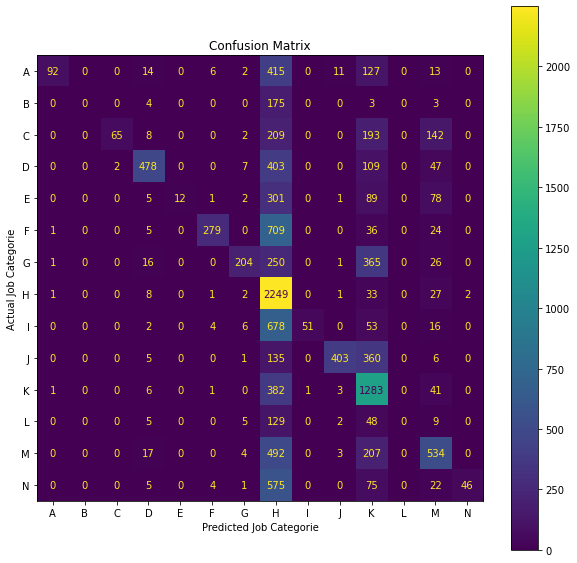

In [25]:
cm = confusion_matrix(val_y, y_pred)

cmd_obj = ConfusionMatrixDisplay(cm, display_labels=list(df_val.sort_values("categorie")["categorie"].unique()))
cmd_obj.plot()
cmd_obj.ax_.set(title='Confusion Matrix', 
                xlabel='Predicted Job Categorie', 
                ylabel='Actual Job Categorie',)

plt.rcParams["figure.figsize"] = (5,5)
plt.show()